<a href="https://colab.research.google.com/github/rnoxy/dl_uwr/blob/summer2024/Assignments/Assignment3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Assignment 3

**Submission deadlines:**
- deadline: last lab session Tuesday, 09.04.2023

**Points:** Aim to get 8 points + 2 extra

### Submission instructions
The class is held remotely. To submit your solutions please show the notebook over the video call. Make sure you know all the questions and answers, and that the notebook contains results (before presentation do `Runtime -> Restart and run all`)

For the problem 2, we provide the starter code,
however, you are not required to use it as long as you properly solve the tasks.

# Problem 1: Classify the Oxford Flowers dataset (Weight & Biases) [6p]

In this task, you will train a convolutional neural network to classify images of flowers from the [Oxford Flowers 102 dataset](https://www.robots.ox.ac.uk/~vgg/data/flowers/102/). The dataset consists of 102 flower categories, and each class has between 40 and 258 images. The images have large scale, pose, and light variations. In addition, there are categories that have large variations within the category and several very similar categories.

    
The dataset is available in `torchvision.datasets.Flower102` class. You can use the following code to load the dataset:

```python
import torchvision
import torchvision.transforms as transforms

dataset = torchvision.datasets.Flower102(root='./data', download=True, transform=transforms.ToTensor())
```

In this task you should run several experiments to classify the images.
In order to track the experiments, you can use the `Weight & Biases` library; see the [documentation](https://docs.wandb.ai/quickstart) for more details.

Implement your code as a single Python script or a Jupyter notebook. Remember to log the experiment configuration, hyperparameters, and results (e.g., training loss, validation loss, accuracy and test loss, accuracy).
For logging, you can use the `wandb.log` function to log the metrics and hyperparameters. You can also log the model architecture, training curves, and other relevant information.

* 1.1 **[2p]**:
    * Your task is to implement a convolutional neural network from scratch using PyTorch.
    * Your CNN should consist of convolutional layers (Conv2D), pooling layers (MaxPooling2D), activation layers (e.g., ReLU), and fully connected layers (if needed).
    * Train your CNN on a small part of the dataset (e.g., 10%, 25%, 50%, 75%, 100% of the original training set) while keeping the validation and test sets constant.

* 1.2 **[1p]**:
    * Input normalization: experiment with different input normalization techniques (e.g., mean subtraction, standardization) and analyze their impact on the model's performance.

* 1.3 **[1p]**:
    * Experiment with different hyperparameters such as learning rate, batch size, number of epochs, and optimizer choice (e.g., SGD, Adam).

* 1.4 **[1p]**: Użyć wbudowanych
    * Modify your CNN architecture to include batch normalization and dropout layers.

* 1.5 **[1p]**:
    * Implement data augmentation techniques such as random rotations, shifts, flips, and zooms on the training dataset.
    * Train your CNN with augmented data and compare the performance with the baseline model trained on the original data.

* 1.6 ***[2p extra points]***:
    * Implement residual connections in your CNN architecture; see the [ResNet paper](https://arxiv.org/abs/1512.03385) for more details.
    * Implement inception modules in your CNN architecture; see the [GoogLeNet paper](https://arxiv.org/abs/1409.4842) for more details.
                

Analyze the results obtained from different experiments.
Discuss the effects of varying training set size, hyperparameters, batch normalization, dropout, and data augmentation on the CNN's performance.
Provide insights into how these factors influence model training, convergence, and generalization.

You can use the `Weight & Biases` reports to present your findings in a comprehensive report or presentation; see the [documentation](https://docs.wandb.ai/quickstart) for more details.




## Imports

In [3]:
!pip install wandb

In [4]:
import torchvision
import torchvision.transforms as transforms
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torch.utils.data import Subset
import itertools
import gc
import numpy as np
import wandb

torch.manual_seed(42)
np.random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
!wandb login

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


## Data

In [6]:
transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor()
])

trainset = torchvision.datasets.Flowers102(root='./data', split='train', download=True, transform=transform)
trainloader_full = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, num_workers=2)

validation_set = torchvision.datasets.Flowers102(root='./data', split='val', download=True, transform=transform)
validationloader = torch.utils.data.DataLoader(validation_set, batch_size=32, shuffle=True, num_workers=2)

testset = torchvision.datasets.Flowers102(root='./data', split='test', download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False, num_workers=2)

100%|██████████| 344862509/344862509 [00:31<00:00, 10784761.68it/s]


Extracting data/flowers-102/102flowers.tgz to data/flowers-102


100%|██████████| 502/502 [00:00<00:00, 1184218.56it/s]


100%|██████████| 14989/14989 [00:00<00:00, 15760446.89it/s]


Dataset Flowers102
    Number of datapoints: 1020
    Root location: ./data
    split=train
    StandardTransform
Transform: Compose(
               Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           ) Dataset Flowers102
    Number of datapoints: 1020
    Root location: ./data
    split=val
    StandardTransform
Transform: Compose(
               Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           ) Dataset Flowers102
    Number of datapoints: 6149
    Root location: ./data
    split=test
    StandardTransform
Transform: Compose(
               Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )

train, valid, test lens: 1020, 1020, 6149
Sample: (tensor([[[0.1333, 0.1294, 0.1255,  ..., 0.1137, 0.1098, 0.1059],
         [0.1216, 0.1333, 0.1294,  ..., 0.1176, 0.1059, 0.1020],
         [0.1294, 0.

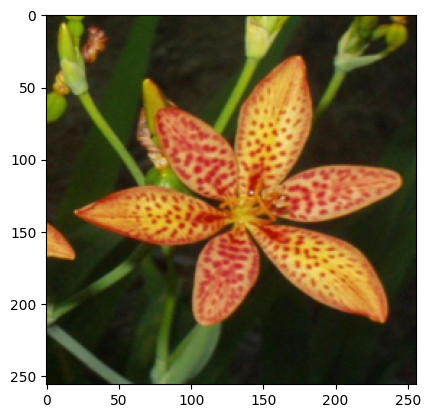

In [7]:
print(trainset, validation_set, testset, end="\n\n")
print(f"train, valid, test lens: {len(trainset)}, {len(validation_set)}, {len(testset)}")
sample = trainset[-1]
print(f"Sample: {sample}")
image, label = sample
print(f"Image size: {image.size()}")
print(f"Label: {label}")

plt.imshow(sample[0].permute(1, 2, 0))

## Problem 1.1

In [8]:
def evaluate_model(model, test_loader, device="cuda"):
    model.to(device)
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            predicted = torch.argmax(outputs, dim=1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy

In [9]:
class CNN(nn.Module):
    def __init__(self, hidden_dim, out_dim, device='cuda'):
        super(CNN, self).__init__()
        self.device = device
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)

        self.fc1_sz = 64 * 62 * 62
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(self.fc1_sz, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 102)

        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x.to(self.device))))
        x = self.pool(self.relu(self.conv2(x)))

        x = x.view(-1, self.fc1_sz)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

def train_model(model, criterion, optimizer, train_loader, validation_loader, num_epochs=5, proj="", name="", conf=None, _wandb=False, verbose=True, device="cuda"):
    try:
        model.to(device)
        if _wandb:
            run = wandb.init(entity="333139", project=f"Assignment3-{proj}", name=f"training_run_{name}", config=conf)

        if verbose:
            pbar = tqdm(range(num_epochs))
        else:
            pbar = range(num_epochs)
        for epoch in pbar:
            running_loss = 0.0
            for i, data in enumerate(train_loader):
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
            model.eval()
            with torch.no_grad():
                val_accuracy = evaluate_model(model, validation_loader, device=device)


            if _wandb:
                run.log({
                    "Loss": running_loss / 100,
                    "val_acc": val_accuracy
                }, step=epoch)

            if verbose:
                pbar.set_description(f'[epoch:\t{epoch + 1}] loss: {running_loss / 100}')
                running_loss = 0.0

    except Exception as e:
        print(e)
    finally:
        if _wandb:
            run.finish()

In [10]:

model = CNN(hidden_dim=512, out_dim=102, device=device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

num_epochs = 30
train_model(model, criterion, optimizer, trainloader_full, validationloader, num_epochs=num_epochs, device=device)

  0%|          | 0/30 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
[epoch:	30] loss: 0.000712845497764647: 100%|██████████| 30/30 [06:09<00:00, 12.30s/it]


In [11]:
accuracy = evaluate_model(model, testloader, device=device)
print("Accuracy on test set: {:.2f}%".format(accuracy))

Accuracy on test set: 18.69%


In [13]:
percentages = [0.1, 0.25, 0.5, 0.75, 1.0]

for pct in percentages:
    model = CNN(hidden_dim=512, out_dim=102, device=device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    trainset_size = int(len(trainset) * pct)
    train_subset, _ = torch.utils.data.random_split(trainset, [trainset_size, len(trainset) - trainset_size])

    trainloader = torch.utils.data.DataLoader(train_subset, batch_size=32, shuffle=True, num_workers=2)
    validationloader = torch.utils.data.DataLoader(validation_set, batch_size=32, shuffle=True, num_workers=2)
    testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False, num_workers=2)

    conf = {
        "percentage_training_data": pct,
        "learning_rate": 0.0001
    }

    train_model(model, criterion, optimizer, trainloader, validationloader, num_epochs=10, proj="percent", name=f"{pct}", conf=conf, device=device, _wandb=True)

    accuracy = evaluate_model(model, testloader, device=device)
    print(f"Accuracy on test set ({pct * 100}% of training data): {accuracy:.2f}%")


wandb: Currently logged in as: 333139. Use `wandb login --relogin` to force relogin


  0%|          | 0/10 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
[epoch:	10] loss: 0.04469749689102173: 100%|██████████| 10/10 [01:03<00:00,  6.34s/it]


Loss,█▇▆▅▅▄▃▃▁▁
val_acc,▁▁▃▂▄▇▄▄▇█
Loss,0.0447
val_acc,5.39216


Accuracy on test set (10.0% of training data): 4.75%


[epoch:	10] loss: 0.07406930088996887: 100%|██████████| 10/10 [01:13<00:00,  7.32s/it]


Loss,█▇▇▇▆▅▄▃▂▁
val_acc,▂▁▃▃▄▆▆▇▇█
Loss,0.07407
val_acc,7.45098


Accuracy on test set (25.0% of training data): 7.22%


[epoch:	10] loss: 0.22472253203392029: 100%|██████████| 10/10 [01:31<00:00,  9.15s/it]


Loss,█▇▇▆▆▅▄▃▂▁
val_acc,▁▂▂▃▃▆▇█▇█
Loss,0.22472
val_acc,10.19608


Accuracy on test set (50.0% of training data): 9.55%


[epoch:	10] loss: 0.0644053727388382: 100%|██████████| 10/10 [01:43<00:00, 10.37s/it]


Loss,██▇▆▅▄▃▂▁▁
val_acc,▁▃▄▅▅▇▇██▇
Loss,0.06441
val_acc,15.19608


Accuracy on test set (75.0% of training data): 14.77%


[epoch:	10] loss: 0.07858246698975563: 100%|██████████| 10/10 [02:00<00:00, 12.08s/it]


Loss,█▇▇▆▅▄▃▂▁▁
val_acc,▁▂▃▅▅▆█▇██
Loss,0.07858
val_acc,19.21569


Accuracy on test set (100.0% of training data): 14.96%


## Problem 1.2

In [14]:
transform_normalize = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


class SubtractMean(object):
    def __call__(self, tensor):
        mean = tensor.mean()
        return tensor - mean

transform_mean_sub = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),
    SubtractMean()
])

In [15]:
trainset_normalize = torchvision.datasets.Flowers102(root='./data', split='train', download=True, transform=transform_normalize)
trainset_mean_sub = torchvision.datasets.Flowers102(root='./data', split='train', download=True, transform=transform_mean_sub)

validationset_normalize = torchvision.datasets.Flowers102(root='./data', split='val', download=True, transform=transform_normalize)
validationset_mean = torchvision.datasets.Flowers102(root='./data', split='val', download=True, transform=transform_mean_sub)

testset_normalize = torchvision.datasets.Flowers102(root='./data', split='test', download=True, transform=transform_normalize)
testset_mean_sub = torchvision.datasets.Flowers102(root='./data', split='test', download=True, transform=transform_mean_sub)

In [16]:
trainloader_full_norm = torch.utils.data.DataLoader(trainset_normalize, batch_size=32, shuffle=True, num_workers=2)
trainloader_full_mean = torch.utils.data.DataLoader(trainset_mean_sub, batch_size=32, shuffle=True, num_workers=2)

validationloader_full_norm = torch.utils.data.DataLoader(validationset_normalize, batch_size=32, shuffle=True, num_workers=2)
validationloader_full_mean = torch.utils.data.DataLoader(validationset_mean, batch_size=32, shuffle=True, num_workers=2)

testloader_norm = torch.utils.data.DataLoader(testset_normalize, batch_size=32, shuffle=False, num_workers=2)
testloader_mean = torch.utils.data.DataLoader(testset_mean_sub, batch_size=32, shuffle=False, num_workers=2)

In [18]:
model = CNN(512, 102).to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters())
num_epochs = 10

train_model(model, criterion, optimizer, trainloader_full_norm, validationloader_full_norm, num_epochs=num_epochs, proj="normalization", name='std', device=device)
acc = evaluate_model(model, testloader_norm, device=device)
print(f"Accuracy on test set: {acc:.2f}%")

[epoch:	10] loss: 1.4802547359466554: 100%|██████████| 10/10 [02:10<00:00, 13.08s/it]


Accuracy on test set: 1.53%


In [19]:
model = CNN(512, 102)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())
num_epochs = 10

train_model(model, criterion, optimizer, trainloader_full_mean, validationloader_full_mean, num_epochs=num_epochs, proj='normalization', name='mean', device=device)
acc = evaluate_model(model, testloader_mean)
print(f"Accuracy on test set: {acc:.2f}%")

[epoch:	10] loss: 0.019908505498897285: 100%|██████████| 10/10 [02:09<00:00, 12.92s/it]


Accuracy on test set: 12.57%


## Problem 1.3

In [ ]:
import itertools

from tqdm import tqdm

learning_rates = [0.0005, 0.0001]
hidd_sizes = [512, 1024, 2048]
batch_sizes = [64, 128]
num_epochs_list = [30, 50]
optimizers = ['Adam']

train_l = {bs: torch.utils.data.DataLoader(trainset, batch_size=bs, shuffle=True, num_workers=2) for bs in batch_sizes}
val_l = {bs: torch.utils.data.DataLoader(validation_set, batch_size=bs, shuffle=True, num_workers=2) for bs in batch_sizes}
test_l = {bs: torch.utils.data.DataLoader(testset, batch_size=bs, shuffle=False, num_workers=2) for bs in batch_sizes}

In [ ]:
import json

prod = itertools.product(learning_rates, hidd_sizes, batch_sizes, num_epochs_list, optimizers)
result = {}

for i, (lr, hidd_size, batch_size, num_epochs, optimizer_name) in enumerate(prod):
    trainloader_full = train_l[batch_size]
    validationloader = val_l[batch_size]
    testloader_full = test_l[batch_size]

    model = CNN(hidd_size, 102)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr) if optimizer_name == 'Adam' else optim.SGD(model.parameters(), lr, momentum=0.9)

    conf = {
        "lr": lr,
        "hidd_size": hidd_size,
        "batch_size": batch_size,
        "num_epochs": num_epochs,
        "optimizer_name": optimizer_name
    }
    conf_str = json.dumps(conf)

    train_model(model, criterion, optimizer, trainloader_full, validationloader, num_epochs=num_epochs, proj="grid", conf=conf)
    result[conf_str] = evaluate_model(model, testloader_full)

In [ ]:
sorted_results = sorted(result.items(), key=lambda x: x[1], reverse=True)

for params, accuracy in sorted_results:
    print(f"Parameters: {params}, Accuracy: {accuracy}")

## Problem 1.4

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms


class CNN(nn.Module):
    def __init__(self, hidden_dim, out_dim):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)

        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 64 * 64, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, out_dim)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax()

        self.dropout = nn.Dropout(0.5)
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm1d(hidden_dim)

    def forward(self, x):
        drop = lambda x: self.dropout(self.relu(x))

        x = self.pool(self.bn1(drop(self.conv1(x))))
        x = self.pool(self.bn2(drop(self.conv2(x))))

        x = x.view(-1, 64 * 64 * 64)
        x = drop(self.bn3(self.fc1(x)))
        x = self.fc2(x)
        return x


In [22]:
model = CNN(hidden_dim=512, out_dim=102).to(device)

criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

num_epochs = 10

train_model(model, criterion, optimizer, trainloader_full, validationloader, num_epochs=num_epochs, proj='drop&batchnorm', name="drop_n_batch", _wandb=True)

[epoch:	10] loss: 0.05846554152667523: 100%|██████████| 10/10 [02:11<00:00, 13.12s/it]


Loss,██▇▇▅▄▃▂▁▁
val_acc,▁▃▄▅▇▇▇███
Loss,0.05847
val_acc,18.52941


In [23]:
evaluate_model(model, testloader)

16.40917222312571

## Problem 1.5

In [24]:
transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor()
])

aug_trans = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5, interpolation=3),
    transforms.ToTensor()
])

In [28]:
def train_model_aug(model, criterion, optimizer, train_loader, validation_loader, num_epochs=5, proj="", name="", conf=None, _wandb=True, verbose=True, device="cuda"):
    model.to(device)
    if _wandb:
        run = wandb.init(entity="333139", project=f"Assignment3-{proj}", name=f"training_run_{name}", config=conf)

    try:
        if verbose:
            pbar = tqdm(range(num_epochs))
        else:
            pbar = range(num_epochs)
        for epoch in pbar:
            running_loss = 0.0
            for i, data in enumerate(train_loader):
                inputs, labels = data
                augmented_inputs = torch.stack([aug_trans(x) for x in inputs])

                inputs, labels = augmented_inputs.to(device), labels.to(device)
                optimizer.zero_grad()


                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
            model.eval()
            with torch.no_grad():
                val_accuracy = evaluate_model(model, validation_loader, device=device)


            if _wandb:
                run.log({
                    "Loss": running_loss / 100,
                    "val_acc": val_accuracy
                }, step=epoch)

            if verbose:
                pbar.set_description(f'[epoch:\t{epoch + 1}] loss: {running_loss / 100}')
                running_loss = 0.0
    except Exception as e:
        print(e)
    finally:
        if _wandb:
            run.finish()


In [31]:
model = CNN(hidden_dim=512, out_dim=102).to(device)

criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

num_epochs = 10
train_model_aug(model, criterion, optimizer, trainloader_full, validationloader, num_epochs=num_epochs, device=device, proj='augmented', name='aug')

Problem at: <ipython-input-28-c90fc9326106> 4 train_model_aug


KeyboardInterrupt: 

In [ ]:

accuracy = evaluate_model(model, testloader, device=device)
print("Accuracy on test set: {:.2f}%".format(accuracy))

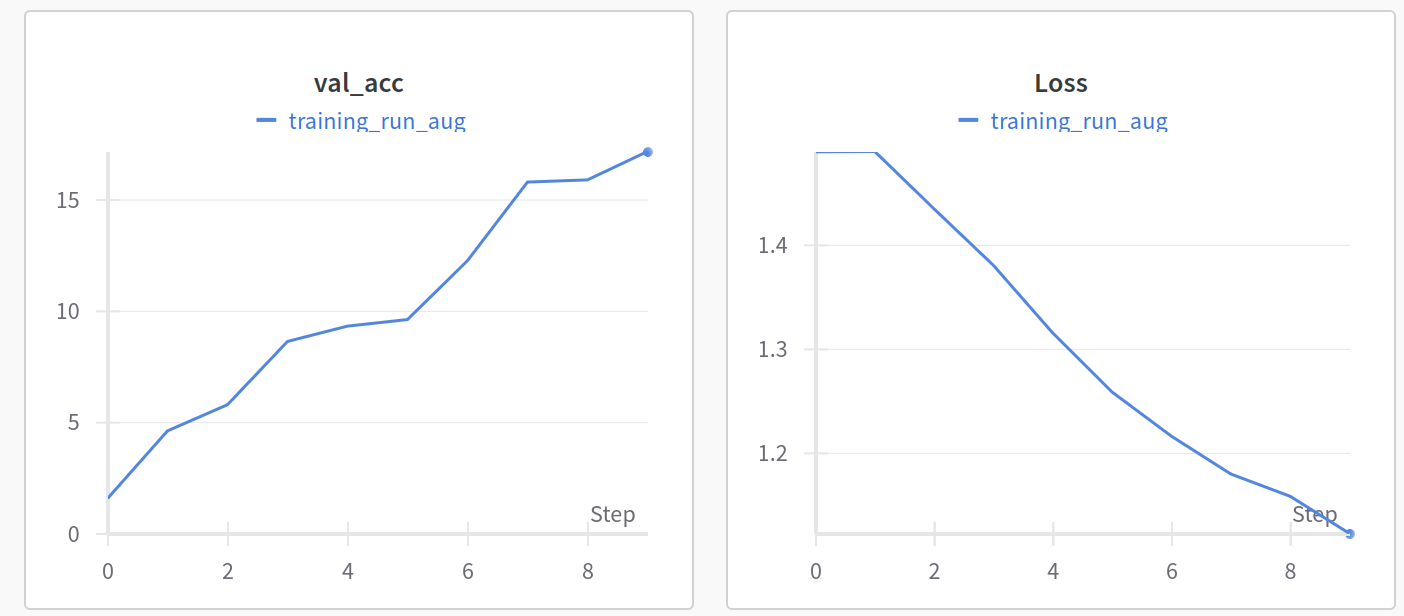

In [32]:
model = CNN(hidden_dim=512, out_dim=102).to(device)

criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

num_epochs = 10
train_model(model, criterion, optimizer, trainloader_full, validationloader, num_epochs=num_epochs, device=device, proj='augmented', name='classic')

[epoch:	10] loss: 0.053541104309260845: 100%|██████████| 10/10 [02:05<00:00, 12.51s/it]


In [33]:
accuracy = evaluate_model(model, testloader, device=device)
print("Accuracy on test set: {:.2f}%".format(accuracy))

Accuracy on test set: 17.04%


## Problem 1.6 - residual

In [39]:
import torch.nn as nn

class ResidualBlock(nn.Module):
    def __init__(self, features, k_size=3, padding=1, device="cuda"):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(features, features, kernel_size=k_size, padding=padding)
        self.conv2 = nn.Conv2d(features, features, kernel_size=k_size, padding=padding)
        self.relu = nn.ReLU()
        self.device = device

    def forward(self, x):
        x_tmp = self.relu(self.conv1(x.to(self.device)))
        x_tmp = self.relu(self.conv2(x_tmp))
        return x_tmp + x

In [40]:
class CNN(nn.Module):
    def __init__(self, hidden_dim, out_dim, device='cuda'):
        super(CNN, self).__init__()
        self.device = device
        self.conv1 = nn.Conv2d(3, 128, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(256 * 32 * 32, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim//2)
        self.fc3 = nn.Linear(hidden_dim//2, out_dim)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

        self.rc1 = ResidualBlock(128, device=self.device)
        self.rc2 = ResidualBlock(128, device=self.device)
        self.rc3 = ResidualBlock(256, device=self.device)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x.to(self.device))))
        x = self.rc1(x)

        x = self.pool(self.relu(self.conv2(x)))
        x = self.rc2(x)

        x = self.pool(self.relu(self.conv3(x)))
        x = self.rc3(x)

        x = x.view(-1, 256 * 32 * 32)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [54]:
import gc
gc.collect()

12877

In [46]:
model = CNN(hidden_dim=512, out_dim=102).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

num_epochs = 10
train_model(model, criterion, optimizer, trainloader_full, validationloader, num_epochs=num_epochs, device=device, proj='bonus', name='residual')

  0%|          | 0/10 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
[epoch:	10] loss: 0.04381182783283293: 100%|██████████| 10/10 [04:13<00:00, 25.36s/it]


In [47]:
accuracy = evaluate_model(model, testloader, device=device)
print("Accuracy on test set: {:.2f}%".format(accuracy))

Accuracy on test set: 14.43%


## Problem 1.6 - inception

In [48]:
transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor()
])


trainset = torchvision.datasets.Flowers102(root='./data', split='train', download=True, transform=transform)
trainloader_full = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, num_workers=2)

validation_set = torchvision.datasets.Flowers102(root='./data', split='val', download=True, transform=transform)
validationloader = torch.utils.data.DataLoader(validation_set, batch_size=32, shuffle=True, num_workers=2)

testset = torchvision.datasets.Flowers102(root='./data', split='test', download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False, num_workers=2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [49]:
class Inception(nn.Module):
    def __init__(self, _in, _out, device="cuda"):
        super(Inception, self).__init__()
        self.conv1 = nn.Conv2d(_in, _out, kernel_size=1)
        self.conv2 = nn.Conv2d(_in, _out, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(_in, _out, kernel_size=5, padding=2)
        self.conv4 = nn.Conv2d(_in, _out, kernel_size=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=(3, 3), stride=(1, 1))
        self.device = device

    def forward(self, x):
        x1 = self.conv1(x)
        x2 = self.conv2(x)
        x3 = self.conv3(x)
        x4 = self.pool(x)
        x4 = self.conv4(x4)

        out = x1
        out += x2
        out += x3
        out += x4

        return out

In [50]:
class CNN(nn.Module):
    def __init__(self, hidden_dim, out_dim, device='cuda'):
        super(CNN, self).__init__()
        self.device = device
        self.inc1 = Inception(3, 32)
        self.inc2 = Inception(32, 64)
        self.inc3 = Inception(64, 256)

        self.fc1 = nn.Linear(256 * 64 * 64, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim//2)
        self.fc3 = nn.Linear(hidden_dim//2, out_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.inc1(x.to(self.device)))
        x = self.relu(self.inc2(x))
        x = self.relu(self.inc3(x))

        x = x.view(-1, 256 * 64 * 64)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [51]:
model = CNN(hidden_dim=512, out_dim=102).to(device)

In [55]:
gc.collect()

0

In [57]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

num_epochs = 10
train_model(model, criterion, optimizer, trainloader_full, validationloader, num_epochs=num_epochs, device=device, proj='bonus', name='inception')

[epoch:	10] loss: 0.0015506744547747076: 100%|██████████| 10/10 [02:13<00:00, 13.30s/it]


In [58]:
accuracy = evaluate_model(model, testloader, device=device)
print("Accuracy on test set: {:.2f}%".format(accuracy))

Accuracy on test set: 18.88%


# Problem 2: Reusing a VGG Network [2p]

Training large-scale models takes much time and resources. It also requires caution when picking hyperparameters. It is a common practice to share learned parameters of large models, and reuse them in different tasks. Weight matrices can be shared, even between entirely different frameworks. Further reading: [How transferable are features in deep neural networks?](https://arxiv.org/abs/1411.1792) by Yosinski et al.

Neural networks trained for image classification might be seen as composed of two elements: a feature extractor, and a classifier. The former is typically made of a stack of convolutional layers, while the latter is the last linear layer of the model.

We will focus on the deepest models - VGG16 and/or VGG19. To complete the task, load pre-trained VGG model. Then:
1. **[1p]** Train the classifier part of the network on the
  [Caltech101](http://www.vision.caltech.edu/Image_Datasets/Caltech101/) dataset of images:
  * replace the classifier with a new randomly initialized one, whose output dimensionality matches
    the number of classes of the Caltech101 dataset. You can replace all layers in the classifier
    part of the VGG with just one affine projection into 102 classes.
  * to significantly reduce training time and avoid destroying network weights early in the training,
    train only the weights of the classifier. You can achieve this by applying the optimization only
    to the classifier's parameters.
    
2. **[1p]** Assess the usefulness of using dropout and data augmentation during classifier training.
  
This procedure should quickly give you less than 10% training errors on the Caltech101 dataset!